In [ ]:
#| default_exp spice.spicer

# SPICER
> Simple SPICE calculations made simple.

In [ ]:
#| export

import datetime as dt
from collections import namedtuple
from math import tau

import dateutil.parser as tparser
import numpy as np
import spiceypy as spice
from astropy import units as u
from astropy.constants import L_sun
from astropy.visualization import quantity_support
from matplotlib import pyplot as plt
from traitlets import Enum, Float, HasTraits, Unicode

import planets
from planetarypy.exceptions import MissingParameterError, SpiceError, SPointNotSetError
from planetarypy.spice.kernels import load_generic_kernels

In [ ]:
#| export

load_generic_kernels()

In [ ]:
#| export

Radii = namedtuple("Radii", "a b c")
"""Simple named Radii structure.

Stores the 3 element radii tuple of SPICE in a named structure.
"""

'Simple named Radii structure.\n\nStores the 3 element radii tuple of SPICE in a named structure.\n'

In [ ]:
#| export


def make_axis_rotation_matrix(direction, angle):
    """
    Create a rotation matrix corresponding to the rotation around a general
    axis by a specified angle.

    R = dd^T + cos(a) (I - dd^T) + sin(a) skew(d)

    Parameters:

        angle : float a
        direction : array d
    """
    d = np.array(direction, dtype=np.float64)
    d /= np.linalg.norm(d)

    eye = np.eye(3, dtype=np.float64)
    ddt = np.outer(d, d)
    skew = np.array([[0, d[2], -d[1]], [-d[2], 0, d[0]], [d[1], -d[0], 0]], dtype=np.float64)

    mtx = ddt + np.cos(angle) * (eye - ddt) + np.sin(angle) * skew
    return mtx

In [ ]:
#| export


class IllumAngles:
    """Managing illumination angles.


    Attributes
    ----------
    phase : traitlets.Float
        Phase angle
    solar : traitlets.Float
        Solar incidence angle
    emission : traitlets.Float
        Surface emission angle
    dphase
    dsolar
    demission
    """

    @classmethod
    def fromtuple(cls, args):
        newargs = np.degrees(args)
        return cls(phase=newargs[0], solar=newargs[1], emission=newargs[2])

    def __init__(self, phase=0, solar=0, emission=0):
        self.phase = (phase * u.deg).to(u.radian)
        self.solar = (solar * u.deg).to(u.radian)
        self.emission = (emission * u.deg).to(u.radian)

    @property
    def dphase(self):
        "float : degree version of self.phase"
        return self.phase.to(u.deg)

    @property
    def dsolar(self):
        "float : degree version of solar incidence angle."
        return self.solar.to(u.deg)

    @property
    def demission(self):
        "float : degree version of emission angle."
        return self.emission.to(u.deg)

    def __str__(self):
        s = "Print-out precision is '.2f'\n"
        s += "Phase: {0:.2f}\nSolar Incidence: {1:.2f}\nEmission: {2:.2f}".format(self.dphase, self.dsolar,
                                                                                  self.demission)
        return s

    def __repr__(self):
        return self.__str__()

In [ ]:
#| export


class SurfaceCoords:
    """Managing SPICE surface coordinates.

    Attributes
    ----------
    lon : traitlets.Float
        Longitude
    lat : traitlets.Float
        Latitude
    radius : traitlets.Float
        Radius of lat/lon location. Could be below or above actual surface.
    dlon
    dlat
    """

    @classmethod
    def fromtuple(cls, args):
        """Initialize object via args tuple.

        This is handy as a tuple is often the output of SPICE functions.

        Parameters
        ----------
        radius: float
            Radius of lat/lon location. Could be below or above actual surface.
        lon: float
            Longitude
        lat: float
            Latitude
        """
        return cls(radius=args[0], lon=np.degrees(args[1]), lat=np.degrees(args[2]))

    def __init__(self, lon=0, lat=0, radius=0):
        self.lon = (lon * u.deg).to(u.radian)
        self.lat = (lat * u.deg).to(u.radian)
        self.radius = radius * u.km

    @property
    def dlon(self):
        return self.lon.to(u.deg)

    @property
    def dlat(self):
        "float : Degree version of radians latitude."
        return self.lat.to(u.deg)

    def __str__(self):
        "Return string with useful summary."
        return "Longitude: {0}\nLatitude: {1}\nRadius: {2}".format(self.dlon, self.dlat, self.radius)

    def __repr__(self):
        return self.__str__()

In [ ]:
#| export


class Spicer(HasTraits):
    """Main Spicer utility class. SPICE body objects should inherit from this.

    Parameters
    ----------
    time : str or dt.datetime
        str should be parseable by dateutil.timeparser

    Attributes
    ----------
    time : datetime.datetime
        Time of Spicer object. Can be changed, which updates all dependent values.
    method : str
        SPICE method flag for surface point interception calculation.
    corr : str
        SPICE method flag for aberration correction
    body : str
        Planetary body string for the SPICE system. To be set either by instance user
        or by subclass.
    ref_frame
    utc
    et
    target_id
    radii
    center_to_sun
    solar_constant
    north_pole
    south_pole
    l_s
    sun_direction
    """

    method = "Near point:ellipsoid"
    corr = Unicode("none")
    target = ""
    _body = Unicode
    _ref_frame = Unicode

    def __init__(self, body, time=None, tilt=0, aspect=0, tau=0.0):
        self._body = body
        if time is None:
            self.time = dt.datetime.now()
        else:
            self.time = tparser.parse(time)
        self._ref_frame = "IAU_" + str(self.body).upper()
        self._tilt = tilt * u.deg
        self._aspect = aspect * u.deg
        self.spoint_set = False
        self.tau = tau

    @property
    def tilt(self):
        return self._tilt

    @tilt.setter
    def tilt(self, val):
        self._tilt = val

    @property
    def aspect(self):
        return self._aspect

    @aspect.setter
    def aspect(self, val):
        self._aspect = val

    @property
    def body(self):
        return self._body

    @body.setter
    def body(self, value):
        self._body = value
        self.ref_frame = "IAU_" + str(value).upper()

    @property
    def ref_frame(self):
        "str: Reference frame for SPICE calculations."
        return self._ref_frame

    @ref_frame.setter
    def ref_frame(self, value):
        self._ref_frame = value

    @property
    def utc(self):
        "str : Isoformat of UTC time."
        return self.time.isoformat()

    @property
    def et(self):
        "float : Returns Ephemeral time value from SPICE for current <time> value."
        return spice.utc2et(self.utc)

    @property
    def target_id(self):
        "int : SPICE Body ID for self.target."
        res = spice.bodn2c(self.target)
        return res

    @property
    def radii(self):
        "namedtuple Radii : Radii values container."
        _, radii = spice.bodvrd(self.target, "RADII", 3)
        return Radii(*radii)

    def body_to_object(self, target):
        """Calculate distance to target.

        Parameters
        ----------
        target : str
            SPICE body string to calculate distance to from self.body.

        Returns
        -------
        tuple : ([float, float, float], float)
            distance vector[3], light-time between body and target

        # TODO: spkezp would be faster, but it uses body codes instead of names
        """
        output = spice.spkpos(target, self.et, self.ref_frame, self.corr, self.body)
        return output

    @property
    def center_to_sun(self):
        "float : Distance of body center to sun [km]."
        cts, lighttime = self.body_to_object("SUN")
        return cts * u.km

    @property
    def solar_constant(self):
        "float : With global value L_s, solar constant at coordinates of body center."
        dist = spice.vnorm(self.center_to_sun.value) * u.km
        return (L_sun / (2 * tau * (dist)**2)).to(u.W / u.m / u.m)

    @property
    def north_pole(self):
        "float[3] : In self.ref_frame coords, the north pole [km]."
        return (0.0, 0.0, self.radii.c)

    @property
    def south_pole(self):
        "float[3] : In self.ref_frame coords, the south pole [km]."
        return (0.0, 0.0, -self.radii.c)

    def srfrec(self, surfcoord, body=None):
        """Convert lon/lat to rectangular coordinates.

        Convert planetocentric longitude and latitude of a surface point on a
        specified body to rectangular coordinates.

        self.target needs to be set for this!

        Parameters
        ----------
        surfcoord : SurfaceCoords
            Instance of SurfaceCoords.
        body : str or int, optional
            SPICE body str (will be converted) or SPICE body id. Default: self.body

        Examples
        --------

        >>> mspice = MarsSpicer()
        >>> print('{0:g} {1:g} {2:g}'.format(*mspice.srfrec(0,85)))
        294.268 0 3363.5
        """
        if body is None:
            body = self.target_id
        if not str(body).isdigit():
            body = spice.bodn2c(body)
        return spice.srfrec(body, surfcoord.lon.value, surfcoord.lat.value)

    def set_spoint_by(self, func_str=None, lon=None, lat=None):
        """Set the current surface point for illumination calculations.

        Parameters
        ----------
        func_str : {'subpnt', 'sincpt'}

        """
        if func_str is not None and func_str not in ["subpnt", "sincpt"]:
            raise NotImplementedError('Only "sincpt" and "subpnt" are supported at this time.')
        elif func_str is not None:
            raise NotImplementedError("not yet implemented.")
            # if not self.instrument or not self.obs:
            #     print("Observer and/or instrument have to be set first.")
            #     return
            # if func_str in 'subpnt':
            #     spoint = self.subpnt()[0]
            # elif func_str in 'sincpt':
            #     spoint = self.sincpt()[0]
            # else:
            #     raise Exception("No valid method recognized.")
        elif None in [lat, lon]:
            raise MissingParameterError("both lat and lon need to be given.")
        else:
            coords = SurfaceCoords(lat=lat, lon=lon)
            spoint = self.srfrec(coords).tolist()
        self.spoint_set = True
        self.spoint = spoint

    @property
    def l_s(self):
        return np.rad2deg(spice.lspcn(self.target, self.et, self.corr))

    @property
    def sun_direction(self):
        if not self.spoint_set:
            raise SPointNotSetError
        return spice.vsub(self.center_to_sun.value, self.spoint)

    @property
    def illum_angles(self):
        """Ilumin returns (trgepoch, srfvec, phase, solar, emission)
        """
        if self.obs is not None:
            output = spice.ilumin(
                "Ellipsoid",
                self.target,
                self.et,
                self.ref_frame,
                self.corr,
                self.obs,
                self.spoint,
            )
            return IllumAngles.fromtuple(output[2:])
        else:
            solar = spice.vsep(self.sun_direction, self.snormal)
            # leaving at 0 what I don't have
            return IllumAngles.fromtuple((0, solar, 0))

    @property
    def snormal(self):
        if not self.spoint_set:
            raise SPointNotSetError
        return spice.surfnm(*self.radii, self.spoint)

    @property
    def coords(self):
        if not self.spoint_set:
            raise SPointNotSetError
        return SurfaceCoords.fromtuple(spice.reclat(self.spoint))

    @property
    def local_soltime(self):
        return spice.et2lst(self.et, self.target_id, self.coords.lon.value, "PLANETOGRAPHIC")[3]

    def _get_flux(self, vector):
        diff_angle = spice.vsep(vector, self.sun_direction)
        if (self.illum_angles.dsolar > 90 * u.deg) or (np.degrees(diff_angle) > 90):
            return 0 * u.W / (u.m * u.m)
        else:
            return (self.solar_constant * np.cos(diff_angle) * np.exp(-self.tau / np.cos(self.illum_angles.solar)))

    @property
    def F_flat(self):
        return self._get_flux(self.snormal)

    @property
    def to_north(self):
        if not self.spoint_set:
            raise SPointNotSetError
        return spice.vsub(self.north_pole, self.spoint)

    @property
    def tilted_normal(self):
        """
        Create a tilted surface normal vector for by amount of self.tilt

        The tilt is applied by rotating the snormal vector towards north.
        """
        if not self.spoint_set:
            raise SPointNotSetError
        # cross product
        axis = spice.vcrss(self.to_north, self.spoint)
        rotmat = make_axis_rotation_matrix(axis, np.radians(self.tilt))
        return np.matrix.dot(rotmat, self.snormal)

    @property
    def F_tilt(self):
        return self._get_flux(self.tilted_normal)

    @property
    def tilted_rotated_normal(self):
        """
        Rotate the tilted normal around the snormal to create an aspect angle.

        Angle `aspect` should be in degrees and is applied clockwise.
        """
        rotmat = make_axis_rotation_matrix(self.snormal, np.radians(self.aspect))
        return np.matrix.dot(rotmat, self.tilted_normal)

    @property
    def F_aspect(self):
        return self._get_flux(self.tilted_rotated_normal)

    def advance_time_by(self, secs):
        self.time += dt.timedelta(seconds=secs)

    def time_series(self, flux_name, dt, no_of_steps=None, provide_times=None):
        """
        Provide time series of fluxes with a <dt> in seconds as sampling
        intervals.

        Parameters
        ----------
        flux_name :
            String. Decides which of flux vector attributes to integrate.
            Should be one of ['F_flat','F_tilt','F_aspect']
        dt :
            delta time for the time series, in seconds
        no_of_steps :
            number of steps to add to time series
        provide_times :
            Should be set to one of ['time','utc','et','l_s'] if wanted.

        Returns
        -------
        if provide_times is None:
            out : ndarray
            Array of evenly spaced flux values, given as E/(dt*m**2).
            I.e. the internal fluxes are multiplied by dt.
        else:
            out : (ndarray, ndarray)
            Tuple of 2 arrays, out[0] being the times, out[1] the fluxes
        """
        saved_time = self.time
        times = []
        fluxes = []
        energies = []
        i = 0
        criteria = i < no_of_steps
        while criteria:
            i += 1
            if provide_times:
                times.append(getattr(self, provide_times))
            fluxes.append(getattr(self, flux_name))
            energies.append(getattr(self, flux_name) * dt * u.s)
            self.advance_time_by(dt)
            criteria = i < no_of_steps

        self.time = saved_time
        energies = (np.array([e.value for e in energies]) * energies[0].unit).to("J/m**2")
        fluxes = np.array([f.value for f in fluxes]) * fluxes[0].unit
        if provide_times:
            return np.array(times), energies
        else:
            return fluxes, energies

    @property
    def subsolar(self):
        # normalize surface point vector:
        uuB = spice.vhat(self.center_to_sun)

        # receive subsolar point in IAU_MARS rectangular coords
        # the *self.radii unpacks the Radii object into 3 arguments.
        v_subsolar = spice.surfpt((0, 0, 0), uuB, *self.radii)

        return v_subsolar

    @property
    def subsolar2(self):
        methods = [
            "Intercept/ellipsoid",
            "Near point/ ellipsoid",
        ]

        return spice.subslr(
            methods[0],
            self.target,
            self.et,
            self.ref_frame,
            self.corr,
            self.target,
        )

    def point_towards_sun(self, pixel_res=0.5):
        """
        Calculate a surface point towards the sun to compute the solar azimuth.

        Instead of going through the effort in defining azimuth origins and positive
        directions here, I return lon/lat for a point that lies within a pixel but
        towards the subsolar point.

        Parameters
        ----------
        pixel_res : float
            Pixel sampling size, required to calculate new point within one pixel of
            the origin (i.e. `spoint`) point.

        Returns
        -------
        dlon, dlat : float
            Lon/Lat in degrees for point towards sun.
        """
        # Check if surface point spoint was set
        if not self.spoint_set:
            raise SPointNotSetError

        # Get the difference vector poB=subsolar-origin with its tail at origin
        # and its head at the subsolar point
        poB = spice.vsub(self.subsolar, self.spoint)

        # the difference vector cuts through the body.
        # we need the tangent vector to the surface at the origin point.
        # vperp receives the perpendicular component of the poB towards the
        # spoint vector
        hpoB = spice.vperp(poB, self.spoint)

        # unitize the tangent vector and then scale it to within a pixel of the
        # origin point
        upoB = spice.vhat(hpoB)

        # get pixel scale in km/pixel and then divide by 2 to insure to stay
        # within a pixel of the origin point
        scale = (pixel_res / 1000.0) / 2.0
        spoB = spice.vscl(scale, upoB)

        # Compute the new point in body fixed. This point will be within a
        # pixel of the origin but in the same direction as the requested la/lon
        # of the point of interest, i.e. the subsolar point
        nB = spice.vadd(self.spoint, spoB)

        coords = SurfaceCoords.fromtuple(spice.reclat(nB))
        return coords.dlon, coords.dlat

    def projected_tilted_rotated_normal(self, pixel_res=0.5):
        hpoB = spice.vperp(self.tilted_rotated_normal, self.snormal)

        upoB = spice.vhat(hpoB)

        scale = (pixel_res / 1000.0) / 2.0
        spoB = spice.vscl(scale, upoB)

        nB = spice.vadd(self.spoint, spoB)

        coords = SurfaceCoords.fromtuple(spice.reclat(nB))
        return coords.dlon, coords.dlat

    def fluxes_around_equator(self, deltalon=10):  # delta between points at equator where flux is calculated
        longitudes = range(0, 360, deltalon)
        fluxes = []
        for lon in longitudes:
            self.set_spoint_by(lat=0, lon=lon)
            fluxes.append(self.F_flat.value)
        plt.plot(longitudes, fluxes)
        plt.xlabel("Longitudes [deg]")
        plt.ylabel("Fluxes [W/m^2]")
        plt.title(f"Fluxes at {self.time.isoformat()[:16]} around the equator.")
        return longitudes, fluxes

/tmp/ipykernel_1309653/4089588791.py:4: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  class Spicer(HasTraits):


In [ ]:
#| export


class MarsSpicer(Spicer):
    target = "MARS"
    obs = Enum([None, "MRO", "MGS", "MEX"])
    instrument = Enum([None, "MRO_HIRISE", "MRO_CRISM", "MRO_CTX"])
    # Coords dictionary to store often used coords
    location_coords = dict(inca=(220.09830399469547, -440.60853011059214, -3340.5081261541495))

    def __init__(self, time=None, obs=None, inst=None, **kwargs):
        """ Initialising MarsSpicer class.

        Demo:
        >>> mspicer = MarsSpicer(time='2007-02-16T17:45:48.642')
        >>> mspicer.goto('inca')
        >>> print('Incidence angle: {0:g}'.format(mspicer.illum_angles.dsolar))
        Incidence angle: 95.5388

        >>> mspicer = MarsSpicer(time='2007-01-27T12:00:00')
        >>> mspicer.set_spoint_by(lon=300, lat = -80)
        >>> print('Incidence angle: {0:g}'.format(mspicer.illum_angles.dsolar))
        Incidence angle: 85.8875
        """
        super().__init__(self.target, time=time, **kwargs)
        self.obs = obs
        self.instrument = inst

    def goto(self, loc_string):
        """Set self.spoint to coordinates as saved in location_coords.

        Currently available locations:
            'inca'  (call like so: mspicer.goto('inca'))
        """
        self.spoint_set = True
        self.spoint = self.location_coords[loc_string.lower()]


class TritonSpicer(Spicer):
    target = "TRITON"
    obs = Enum([None, "EARTH"])

    def __init__(self, time=None, obs=None, inst=None):
        super().__init__(self.target, time=time)
        self.obs = obs
        self.instrument = inst


class EnceladusSpicer(Spicer):
    target = "ENCELADUS"
    obs = Enum([None, "EARTH"])

    def __init__(self, time=None, obs=None, inst=None):
        super().__init__(self.target, time=time)
        self.obs = obs
        self.instrument = inst


class PlutoSpicer(Spicer):
    target = "PLUTO"
    obs = Enum([None, "EARTH"])

    def __init__(self, time=None, obs=None, inst=None):
        super().__init__(self.target, time=time)
        self.obs = obs
        self.instrument = inst


class EarthSpicer(Spicer):
    target = "EARTH"
    obs = Enum([None, "EARTH"])

    def __init__(self, time=None, obs=None, inst=None):
        super().__init__(self.target, time=time)
        self.obs = obs
        self.instrument = inst


class MoonSpicer(Spicer):
    target = "MOON"
    obs = Enum([None, "EARTH"])
    constants = planets.Moon

    def __init__(self, time=None, obs=None, inst=None):
        super().__init__(self.target, time=time)
        self.obs = obs
        self.instrument = inst

    @property
    def albedo_var(self):
        # motivated by P. Hayne's heat1d code
        a, b = self.constants.albedoCoef
        A0 = self.constants.albedo
        i = self.illum_angles.solar.value
        return A0 + a * (i / (np.pi / 4))**3 + b * (i / (np.pi / 2))**8

    @property
    def Qs(self):
        return self.F_flat.value * (1 - self.albedo_var)

    def time_series(self, flux_name, dt, no_of_steps=None, provide_times=None):
        """
        Provide time series of fluxes with a <dt> in seconds as sampling
        intervals.

        Parameters
        ----------
        flux_name :
            String. Decides which of flux vector attributes to integrate.
            Should be one of ['F_flat','F_tilt','F_aspect']
        dt :
            delta time for the time series, in seconds
        no_of_steps :
            number of steps to add to time series
        provide_times :
            Should be set to one of ['time','utc','et','l_s'] if wanted.

        Returns
        -------
        if provide_times is None:
            out : ndarray
            Array of evenly spaced flux values, given as E/(dt*m**2).
            I.e. the internal fluxes are multiplied by dt.
        else:
            out : (ndarray, ndarray)
            Tuple of 2 arrays, out[0] being the times, out[1] the fluxes
        """
        saved_time = self.time
        times = []
        fluxes = []
        energies = []
        self.Qs_series = []
        i = 0
        criteria = i < no_of_steps
        while criteria:
            i += 1
            if provide_times:
                times.append(getattr(self, provide_times))
            fluxes.append(getattr(self, flux_name))
            energies.append(getattr(self, flux_name) * dt * u.s)
            self.Qs_series.append(self.Qs)
            self.advance_time_by(dt)
            criteria = i < no_of_steps

        self.time = saved_time
        energies = (np.array([e.value for e in energies]) * energies[0].unit).to("J/m**2")
        fluxes = np.array([f.value for f in fluxes]) * fluxes[0].unit
        if provide_times:
            return np.array(times), energies
        else:
            return fluxes, energies


def Mars_Ls_now():
    ms = MarsSpicer()
    return round(ms.l_s, 1)

In [ ]:
moon = MoonSpicer("2022-02-22T00:00:00")

In [ ]:
moon.time

datetime.datetime(2022, 2, 22, 0, 0)

In [ ]:
moon.center_to_sun

<Quantity [ 5.30952610e+07, -1.38221350e+08, -3.94184388e+06] km>

In [ ]:
moon.solar_constant

<Quantity 1388.44815101 W / m2>

In [ ]:
moon.set_spoint_by(lat=0, lon=0)

In [ ]:
moon.tilt = 30

In [ ]:
moon.F_flat

<Quantity 497.68762465 W / m2>

In [ ]:
moon.F_tilt

<Quantity 412.53511461 W / m2>

In [ ]:
moon.F_aspect

<Quantity 412.53511461 W / m2>

In [ ]:
moon.aspect = 180

In [ ]:
moon.F_tilt

<Quantity 412.53511461 W / m2>

In [ ]:
moon.F_aspect

<Quantity 449.48513759 W / m2>

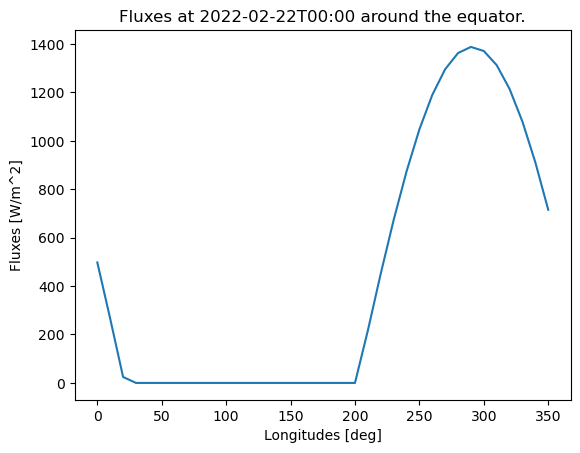

In [ ]:
lons, fluxes = moon.fluxes_around_equator()

In [ ]:
#| hide
from nbdev import nbdev_export

nbdev_export()